## Import Libraries

In [4]:
from typing_extensions import TypedDict
from typing import Literal

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition


import random
from IPython.display import display, Image
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Simple Graph

### State

State are structured data flowing between edges
Nodes are function that process and change state

In [8]:
class State(TypedDict):
    graph_state: str

In [4]:
def node1(state: State) -> str:
    print("=== Node 1 ===")
    return {"graph_state": state['graph_state'] + " I invest in"}

def node2(state: State) -> str:
    print("=== Node 2 ===")
    return {"graph_state": state['graph_state'] + " Stocks"}

def node3(state: State) -> str:
    print("=== Node 3 ===")
    return {"graph_state": state['graph_state'] + " Crypto"}

### Edge

Connecting state

In [5]:
# Conditional edge

def decide_investment(state: State) -> Literal["node2", "node3"]:
    print("=== Decision Node ===")
    
    input = state['graph_state']
    
    if random.random() < 0.5:
        return "node2"
    else:
        return "node3"

### Graph

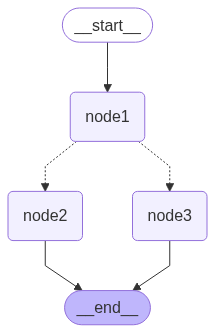

In [6]:
# Define the graph
builder = StateGraph(State)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)

# Set entrypoint
# builder.set_entry_point("node1")

# Logic
builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_investment)
builder.add_edge("node2", END)
builder.add_edge("node3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"graph_state": "Hello, "})

=== Node 1 ===
=== Decision Node ===
=== Node 3 ===


{'graph_state': 'Hello,  I invest in Crypto'}

## Chain

### Messages

In [2]:
messages = [
    AIMessage(content="Do you invest in Stock Market?", name="Model"),
    HumanMessage(content="Yes, that's right", name="Human"),
    AIMessage(content="Nice, what would you like to learn", name="Model"),
    HumanMessage(content="I would like to learn about financial statement", name="Human"),   
]

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

Do you invest in Stock Market?
================================ Human Message =================================
Name: Human

Yes, that's right
================================== Ai Message ==================================
Name: Model

Nice, what would you like to learn
================================ Human Message =================================
Name: Human

I would like to learn about financial statement


### Chat Models

In [3]:
llm = ChatOpenAI(model="gpt-4o-mini")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [4]:
print(result.content)

Financial statements are crucial for understanding a company's financial health and making informed investment decisions. Here are the three primary financial statements you should be familiar with:

1. **Income Statement**: 
   - Also known as the profit and loss statement, it summarizes a company's revenues and expenses over a specific period, usually a quarter or a year.
   - Key components:
     - **Revenue**: The total income generated from sales of goods or services.
     - **Cost of Goods Sold (COGS)**: The direct costs attributable to the production of the goods sold by the company.
     - **Gross Profit**: Revenue minus COGS.
     - **Operating Expenses**: Costs required to run the business (such as selling, general, and administrative expenses).
     - **Net Income**: The profit after all expenses, taxes, and costs have been deducted from total revenue.

2. **Balance Sheet**: 
   - A snapshot of a company's financial position at a specific point in time, detailing assets, lia

In [5]:
result.response_metadata

{'token_usage': {'completion_tokens': 541,
  'prompt_tokens': 54,
  'total_tokens': 595,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-mini-2024-07-18',
 'system_fingerprint': 'fp_51db84afab',
 'id': 'chatcmpl-C8ILNZYubVGo9zLQTmvZHVQ3NkHBf',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

### Tools

In [6]:
# Simple tool function
def multiply(a: int, b: int) -> int:
    return a * b

llm_tool = llm.bind_tools([multiply])

In [7]:
tool_call = llm_tool.invoke([HumanMessage(content="What is 50 x 12?")])

In [8]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_OfUsCwhME1AfcE4qfXgDAZXK',
  'function': {'arguments': '{"a":50,"b":12}', 'name': 'multiply'},
  'type': 'function'}]

In [9]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 50, 'b': 12},
  'id': 'call_OfUsCwhME1AfcE4qfXgDAZXK',
  'type': 'tool_call'}]

### MessagesState + MemorySaver checkpoint

In [ ]:
# Example add_messages with langgraph.graph.messages
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='e278be8e-e4a8-48a5-bc93-48e12712f88d'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='8c3d28f0-73e1-402b-aff1-71dd2b38242e'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='6882c5b8-e92a-4158-8039-1c48ec52d96c')]

In [12]:
class MessageState(MessagesState):
    pass

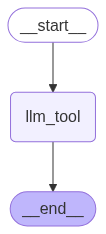

In [30]:
memory = MemorySaver()

def tooling_llm(state: MessageState):
    return {"messages": [llm_tool.invoke(state["messages"])]}

builder = StateGraph(MessageState)
builder.add_node("llm_tool", tooling_llm)
builder.add_edge(START, "llm_tool")
builder.add_edge("llm_tool", END)

graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
config = {"configurable": {"thread_id": "BangDer"}}

In [32]:
message = graph.invoke({"messages": [HumanMessage(content="Hello")]}, config=config)

In [33]:
for m in message['messages']:
    print(m.content)

Hello
Hello! How can I assist you today?


In [34]:
message = graph.invoke({"messages": [HumanMessage(content="What is Jakarta most visited mall")]}, config=config)

In [35]:
for m in message['messages']:
    print(m.content)

Hello
Hello! How can I assist you today?
What is Jakarta most visited mall
The most visited mall in Jakarta is often considered to be "Grand Indonesia." It is a large shopping complex that offers a wide range of shopping, dining, and entertainment options. Grand Indonesia is known for its upscale brands, diverse food choices, and vibrant atmosphere, making it a popular destination for both locals and tourists. Other notable malls in Jakarta include Plaza Indonesia and Mall Taman Anggrek.


In [46]:
state = graph.get_state(config=config)
for message in state.values['messages']:
    print(message.content)

Hello
Hello! How can I assist you today?
What is Jakarta most visited mall
The most visited mall in Jakarta is often considered to be "Grand Indonesia." It is a large shopping complex that offers a wide range of shopping, dining, and entertainment options. Grand Indonesia is known for its upscale brands, diverse food choices, and vibrant atmosphere, making it a popular destination for both locals and tourists. Other notable malls in Jakarta include Plaza Indonesia and Mall Taman Anggrek.


## Router

In [19]:
class MessageState(MessagesState):
    pass

def multiply(a: int, b: int) -> int:
    """Multiply a and b"""
    return a * b

llm = ChatOpenAI(model="gpt-4o-mini")
llm_tool = llm.bind_tools([multiply])

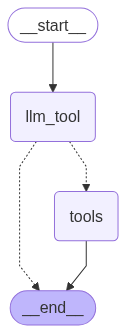

In [27]:
def tool_with_llm(state: MessageState):
    return {"messages": [llm_tool.invoke(state["messages"])]}

memory = MemorySaver()
builder = StateGraph(MessageState)
builder.add_node("llm_tool", tool_with_llm)
builder.add_node("tools", ToolNode([multiply]))

builder.add_edge(START, "llm_tool")
builder.add_conditional_edges("llm_tool", tools_condition)
builder.add_edge("tools", END)

graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
config = {"configurable": {"thread_id": "User2"}}

In [ ]:
messages = [HumanMessage(content="What is 50 x 12?")]
result = graph.invoke({"messages": messages}, config=config)

In [36]:
messages = [HumanMessage(content="Explain multiplier for 5 years kids")]
result = graph.invoke({"messages": messages}, config=config)

In [ ]:
for m in result['messages']:
    print(m.content) 

What is 50 x 12?

600
Explain multiplier for 5 years kids
A multiplier is like a magic number that helps us add the same number many times. 

Imagine you have 5 groups of 2 apples. Instead of counting each apple one by one, you can use a multiplier to make it faster. If you say "2 apples" and then "5 groups," you can find out how many apples there are in total by multiplying:

- So, 2 apples in each group × 5 groups = 10 apples.

This way, multiplying helps us find big numbers quickly without counting everything one by one!


## Agent

In [5]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_tools = llm.bind_tools(tools)

In [7]:
sys_prompt = SystemMessage(content="You are a helpful assistant tasked with writing performing arithmetic on a set of inputs.")
def assistant(state: MessagesState):
    return {"messages": [llm_tools.invoke([sys_prompt] + state["messages"])]}

The main idea of agent is we can node back to assistant node to process next tool if needed

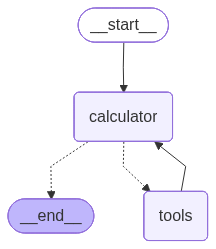

In [33]:
memory = MemorySaver()

builder = StateGraph(MessagesState)
builder.add_node("calculator", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "calculator")
builder.add_conditional_edges("calculator", tools_condition)
builder.add_edge("tools", "calculator")
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
config = {"configurable": {"thread_id": "User3"}}
messages = [HumanMessage(content="Add 10 and 50 then multiply with 5 then divide with 2")]
result = graph.invoke({"messages": messages}, config=config)

In [35]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Add 10 and 50 then multiply with 5 then divide with 2
================================== Ai Message ==================================
Tool Calls:
  add (call_OqduzNisLVGplpHUbkQKiR99)
 Call ID: call_OqduzNisLVGplpHUbkQKiR99
  Args:
    a: 10
    b: 50
  multiply (call_6mqcYBm7rjb6sTt2ZoDkHnUm)
 Call ID: call_6mqcYBm7rjb6sTt2ZoDkHnUm
  Args:
    a: 60
    b: 5
  divide (call_3pKIzfrWwRgcx4SYejpPh4fV)
 Call ID: call_3pKIzfrWwRgcx4SYejpPh4fV
  Args:
    a: 300
    b: 2
================================= Tool Message =================================
Name: add

60
================================= Tool Message =================================
Name: multiply

300
================================= Tool Message =================================
Name: divide

150.0
================================== Ai Message ==================================

Here's the step-by-step calculation:

1. Add 10 and 50: \(10 + 50 =

In [37]:
messages = [HumanMessage(content="Give me some fact based on that number")]
result = graph.invoke({"messages": messages}, config=config)

In [38]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Add 10 and 50 then multiply with 5 then divide with 2
================================== Ai Message ==================================
Tool Calls:
  add (call_OqduzNisLVGplpHUbkQKiR99)
 Call ID: call_OqduzNisLVGplpHUbkQKiR99
  Args:
    a: 10
    b: 50
  multiply (call_6mqcYBm7rjb6sTt2ZoDkHnUm)
 Call ID: call_6mqcYBm7rjb6sTt2ZoDkHnUm
  Args:
    a: 60
    b: 5
  divide (call_3pKIzfrWwRgcx4SYejpPh4fV)
 Call ID: call_3pKIzfrWwRgcx4SYejpPh4fV
  Args:
    a: 300
    b: 2
================================= Tool Message =================================
Name: add

60
================================= Tool Message =================================
Name: multiply

300
================================= Tool Message =================================
Name: divide

150.0
================================== Ai Message ==================================

Here's the step-by-step calculation:

1. Add 10 and 50: \(10 + 50 =

## Tes